In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# Preparing Data for Clustering


In [2]:
data = pd.read_csv("csvs\p.csv", index_col=0)
data.index = range(len(data))
data


start_time             end_time  start_station_id  \
0       2018-01-01 00:24:00  2018-01-01 00:42:00              3124   
1       2018-01-01 00:38:00  2018-01-01 10:10:00              3023   
2       2018-01-01 00:48:00  2018-01-01 01:10:00              3026   
3       2018-01-01 01:03:00  2018-01-01 01:24:00              3045   
4       2018-01-01 01:05:00  2018-01-01 01:09:00              3115   
...                     ...                  ...               ...   
668579  2018-12-31 23:18:00  2019-01-01 00:04:00              3037   
668580  2018-12-31 23:25:00  2019-01-01 00:06:00              3168   
668581  2018-12-31 23:26:00  2019-01-01 06:44:00              3026   
668582  2018-12-31 23:33:00  2018-12-31 23:47:00              3063   
668583  2018-12-31 23:39:00  2018-12-31 23:49:00              3007   

        end_station_id  bike_id  user_type              start_station_name  \
0                 3073     3708   Indego30                Race Street Pier   
1                 3066     3288  Indego365              Rittenhouse Square   
2                 3023    11735   Indego30                     2nd & South   
3                 3037     5202   Indego30                   13th & Locust   
4                 3058     5142   Indego30             19th & Girard, PTTI   
...                ...      ...        ...                             ...   
668579            3037    14519   Day Pass  Pennsylvania Convention Center   
668580            3168    11891   Indego30                   20th & Sansom   
668581            3026     5410   Indego30                     2nd & South   
668582            3150     2701   Day Pass                     17th & Pine   
668583            3049     3471   Indego30          11th & Pine, Kahn Park   

                             end_station_name  
0                         9th & Spring Garden  
1                              19th & Lombard  
2                          Rittenhouse Square  
3              Pennsylvania Convention Center  
4                            20th & Fairmount  
...                                       ...  
668579         Pennsylvania Convention Center  
668580                          20th & Sansom  
668581                            2nd & South  
668582  15th & Castle, DiSilvestro Playground  
668583                        Foglietta Plaza  

[668584 rows x 8 columns]

In [3]:
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])


## Calculate Trip Length


In [4]:
delta = pd.DataFrame(
    {'timedelta': data["end_time"]-data["start_time"]})
delta


timedelta
0      0 days 00:18:00
1      0 days 09:32:00
2      0 days 00:22:00
3      0 days 00:21:00
4      0 days 00:04:00
...                ...
668579 0 days 00:46:00
668580 0 days 00:41:00
668581 0 days 07:18:00
668582 0 days 00:14:00
668583 0 days 00:10:00

[668584 rows x 1 columns]

### convert trip length to minutes


In [5]:
tripLen = delta["timedelta"].dt.components[["days", "hours", "minutes"]]
tripLenDf = pd.DataFrame(
    {'trip_len_in_min': tripLen["days"]*24*60+tripLen["hours"]*60+tripLen["minutes"]})
tripLenDf


trip_len_in_min
0                    18
1                   572
2                    22
3                    21
4                     4
...                 ...
668579               46
668580               41
668581              438
668582               14
668583               10

[668584 rows x 1 columns]

In [6]:
j = data.join(tripLenDf, how='outer')
j


start_time            end_time  start_station_id  \
0      2018-01-01 00:24:00 2018-01-01 00:42:00              3124   
1      2018-01-01 00:38:00 2018-01-01 10:10:00              3023   
2      2018-01-01 00:48:00 2018-01-01 01:10:00              3026   
3      2018-01-01 01:03:00 2018-01-01 01:24:00              3045   
4      2018-01-01 01:05:00 2018-01-01 01:09:00              3115   
...                    ...                 ...               ...   
668579 2018-12-31 23:18:00 2019-01-01 00:04:00              3037   
668580 2018-12-31 23:25:00 2019-01-01 00:06:00              3168   
668581 2018-12-31 23:26:00 2019-01-01 06:44:00              3026   
668582 2018-12-31 23:33:00 2018-12-31 23:47:00              3063   
668583 2018-12-31 23:39:00 2018-12-31 23:49:00              3007   

        end_station_id  bike_id  user_type              start_station_name  \
0                 3073     3708   Indego30                Race Street Pier   
1                 3066     3288  Indego365              Rittenhouse Square   
2                 3023    11735   Indego30                     2nd & South   
3                 3037     5202   Indego30                   13th & Locust   
4                 3058     5142   Indego30             19th & Girard, PTTI   
...                ...      ...        ...                             ...   
668579            3037    14519   Day Pass  Pennsylvania Convention Center   
668580            3168    11891   Indego30                   20th & Sansom   
668581            3026     5410   Indego30                     2nd & South   
668582            3150     2701   Day Pass                     17th & Pine   
668583            3049     3471   Indego30          11th & Pine, Kahn Park   

                             end_station_name  trip_len_in_min  
0                         9th & Spring Garden               18  
1                              19th & Lombard              572  
2                          Rittenhouse Square               22  
3              Pennsylvania Convention Center               21  
4                            20th & Fairmount                4  
...                                       ...              ...  
668579         Pennsylvania Convention Center               46  
668580                          20th & Sansom               41  
668581                            2nd & South              438  
668582  15th & Castle, DiSilvestro Playground               14  
668583                        Foglietta Plaza               10  

[668584 rows x 9 columns]

### add month, day of week and starting time column


In [7]:
times = pd.Series(data['start_time'])
timesDf = pd.DataFrame(
    {'month': times.dt.month, 'day_of_week': times.dt.day_of_week, 'start_time_in_min': 60*times.dt.hour+times.dt.minute})
timesDf


month  day_of_week  start_time_in_min
0           1            0                 24
1           1            0                 38
2           1            0                 48
3           1            0                 63
4           1            0                 65
...       ...          ...                ...
668579     12            0               1398
668580     12            0               1405
668581     12            0               1406
668582     12            0               1413
668583     12            0               1419

[668584 rows x 3 columns]

In [8]:
j = j.join(timesDf, how='outer')
j = j.drop(["start_time", "end_time"], axis=1)
j


start_station_id  end_station_id  bike_id  user_type  \
0                   3124            3073     3708   Indego30   
1                   3023            3066     3288  Indego365   
2                   3026            3023    11735   Indego30   
3                   3045            3037     5202   Indego30   
4                   3115            3058     5142   Indego30   
...                  ...             ...      ...        ...   
668579              3037            3037    14519   Day Pass   
668580              3168            3168    11891   Indego30   
668581              3026            3026     5410   Indego30   
668582              3063            3150     2701   Day Pass   
668583              3007            3049     3471   Indego30   

                    start_station_name                       end_station_name  \
0                     Race Street Pier                    9th & Spring Garden   
1                   Rittenhouse Square                         19th & Lombard   
2                          2nd & South                     Rittenhouse Square   
3                        13th & Locust         Pennsylvania Convention Center   
4                  19th & Girard, PTTI                       20th & Fairmount   
...                                ...                                    ...   
668579  Pennsylvania Convention Center         Pennsylvania Convention Center   
668580                   20th & Sansom                          20th & Sansom   
668581                     2nd & South                            2nd & South   
668582                     17th & Pine  15th & Castle, DiSilvestro Playground   
668583          11th & Pine, Kahn Park                        Foglietta Plaza   

        trip_len_in_min  month  day_of_week  start_time_in_min  
0                    18      1            0                 24  
1                   572      1            0                 38  
2                    22      1            0                 48  
3                    21      1            0                 63  
4                     4      1            0                 65  
...                 ...    ...          ...                ...  
668579               46     12            0               1398  
668580               41     12            0               1405  
668581              438     12            0               1406  
668582               14     12            0               1413  
668583               10     12            0               1419  

[668584 rows x 10 columns]

### replace user type string with ids


In [9]:
mapping = {'Indego30': 1, 'Indego365': 2, 'Day Pass': 3,
           'One Day Pass': 3, "IndegoFlex": 4, "Walk-up": 5}
j = j.replace({"user_type": mapping})
j


start_station_id  end_station_id  bike_id  user_type  \
0                   3124            3073     3708          1   
1                   3023            3066     3288          2   
2                   3026            3023    11735          1   
3                   3045            3037     5202          1   
4                   3115            3058     5142          1   
...                  ...             ...      ...        ...   
668579              3037            3037    14519          3   
668580              3168            3168    11891          1   
668581              3026            3026     5410          1   
668582              3063            3150     2701          3   
668583              3007            3049     3471          1   

                    start_station_name                       end_station_name  \
0                     Race Street Pier                    9th & Spring Garden   
1                   Rittenhouse Square                         19th & Lombard   
2                          2nd & South                     Rittenhouse Square   
3                        13th & Locust         Pennsylvania Convention Center   
4                  19th & Girard, PTTI                       20th & Fairmount   
...                                ...                                    ...   
668579  Pennsylvania Convention Center         Pennsylvania Convention Center   
668580                   20th & Sansom                          20th & Sansom   
668581                     2nd & South                            2nd & South   
668582                     17th & Pine  15th & Castle, DiSilvestro Playground   
668583          11th & Pine, Kahn Park                        Foglietta Plaza   

        trip_len_in_min  month  day_of_week  start_time_in_min  
0                    18      1            0                 24  
1                   572      1            0                 38  
2                    22      1            0                 48  
3                    21      1            0                 63  
4                     4      1            0                 65  
...                 ...    ...          ...                ...  
668579               46     12            0               1398  
668580               41     12            0               1405  
668581              438     12            0               1406  
668582               14     12            0               1413  
668583               10     12            0               1419  

[668584 rows x 10 columns]

### add same start end column


In [10]:
sameStartEndDf = pd.DataFrame(
    {'same_start_end': data['start_station_id'] == data['end_station_id']})
sameStartEndDf


same_start_end
0                False
1                False
2                False
3                False
4                False
...                ...
668579            True
668580            True
668581            True
668582           False
668583           False

[668584 rows x 1 columns]

In [11]:
j = j.drop(["start_station_id", "end_station_id", "bike_id",
            "start_station_name", "end_station_name"], axis=1)
j = j.join(pd.DataFrame(sameStartEndDf), how='outer')
j


user_type  trip_len_in_min  month  day_of_week  start_time_in_min  \
0               1               18      1            0                 24   
1               2              572      1            0                 38   
2               1               22      1            0                 48   
3               1               21      1            0                 63   
4               1                4      1            0                 65   
...           ...              ...    ...          ...                ...   
668579          3               46     12            0               1398   
668580          1               41     12            0               1405   
668581          1              438     12            0               1406   
668582          3               14     12            0               1413   
668583          1               10     12            0               1419   

        same_start_end  
0                False  
1                False  
2                False  
3                False  
4                False  
...                ...  
668579            True  
668580            True  
668581            True  
668582           False  
668583           False  

[668584 rows x 6 columns]

# Geo stuff


In [12]:
data.drop(['bike_id', 'start_station_id', 'end_station_id',
           'end_station_name', 'end_time', 'start_time'], axis=1, inplace=True)

data


user_type              start_station_name
0        Indego30                Race Street Pier
1       Indego365              Rittenhouse Square
2        Indego30                     2nd & South
3        Indego30                   13th & Locust
4        Indego30             19th & Girard, PTTI
...           ...                             ...
668579   Day Pass  Pennsylvania Convention Center
668580   Indego30                   20th & Sansom
668581   Indego30                     2nd & South
668582   Day Pass                     17th & Pine
668583   Indego30          11th & Pine, Kahn Park

[668584 rows x 2 columns]

In [13]:
print("We have {0} different start stations.".format(
    data['start_station_name'].nunique()))
only_start = data['start_station_name'].sort_values().unique()
only_start


We have 135 different start stations.


array(['10th & Chestnut', '10th & Federal', '11th & Market',
       '11th & Pine, Kahn Park',
       '11th & Poplar, John F. Street Community Center', '11th & Reed',
       '11th & South', '11th & Washington', '12th & Callowhill',
       '12th & Chestnut', '12th & Filbert', '12th & Normandy',
       '12th & Passyunk', '13th & Locust', '13th & Montgomery',
       '15th & Castle, DiSilvestro Playground', '15th & Kitty Hawk',
       '15th & Market', '15th & South', '15th & Spruce', '17th & Girard',
       '17th & Locust', '17th & Pine', '17th & Sansom',
       '17th & Spring Garden', '18th & Fernon, Aquinas Center',
       '18th & JFK', '18th & Washington, Chew Playground',
       '19th & Girard, PTTI', '19th & Lombard', '19th & Market',
       '20th & Fairmount', '20th & Market', '20th & Race',
       '20th & Sansom', '21st & Catharine',
       '21st & Winter, Franklin Institute', '22nd & Cecil B. Moore',
       '22nd & Federal', '23rd & Fairmount', '23rd & Market',
       '23rd & South'

In [14]:
educational_institutions = ["Health Sciences Drive", "Dornsife Center", "38th & Spruce", "Barnes Foundation", "Free Library of Philadelphia - Central Library", "Girard & Hutchinson",
                            '13th & Montgomery', "15th & Spruce", '19th & Girard, PTTI', '24th & Cecil B. Moore, Cecil B. Moore Library', '2nd & Race', 'Temple University Station', 'Thompson & Palmer, Adaire School',
                            'University City Station']


In [15]:
parking_lots = ["ParkWest Town Center", '9th & Arch', '38th & Powelton',
                '12th & Filbert', "17th & Locust", '17th & Pine', '24th & Sansom', '2nd & South', '38th & Market']


In [16]:
sights_or_parks = ['11th & Pine, Kahn Park', '15th & Castle, DiSilvestro Playground', '17th & Sansom', '18th & Washington, Chew Playground', '20th & Sansom', "21st & Winter, Franklin Institute",
                   '25th & Locust', '27th & Master, Athletic Recreation Center', '32nd & Baring, Drexel Park', 'Race Street Pier', 'Rittenhouse Square', "Rodin Museum",  'Virtual Station', 'Welcome Park, NPS',
                   "Philadelphia Zoo", "Philadelphia Museum of Art", "Pennsylvania Convention Center", "Pennsylvania & Fairmount Perelman Building", "Parkside & Belmont, Case Building", "ParkWest Town Center",
                   "Municipal Services Building Plaza", "Moyamensing & Tasker", "Independence Mall, NPS", "Front & Carpenter", "Foglietta Plaza", "Fairmount & Ridge", "Del. River Trail & Penn St.", "Crescent Park",
                   "Broad & Pattison, BSL", "Broad & Federal", "8th & Mifflin, Bok Building", "6th & Race", "6th & Fairmount", "43rd & Chester, Clark Park", "4th & Walnut, NPS", '4th & Washington']


In [17]:
pt_stations = ["Parkside & Belmont", "Girard Station, MFL", "BSL", "Broad & Girard", "Broad & Federal", "Berks Station, MFL",
               "Amtrak 30th Street Station", "9th & Spring Garden", "9th & Locust", "8th & Market", "7th & Fitzwater", "6th & Berks", "Market St & S 38th St", '3rd & Girard',
               "40th & Baltimore, Trolley Portal", "40th & Spruce", "40th Street Station, MFL", "43rd & Chester, Clark Park", '46th Street Station, MFL', '8th & Spruce', '4th & Bainbridge', '11th & Market',
               '11th & Poplar, John F. Street Community Center', "11th & South", "12th & Chestnut", '13th & Locust', '15th & Kitty Hawk', '15th & Market', '17th & Girard', '17th & Spring Garden', '18th & JFK', '19th & Lombard',
               '19th & Market', '20th & Fairmount', "20th & Market", '20th & Race', '22nd & Cecil B. Moore', '22nd & Federal', '23rd & Fairmount', '23rd & Market', '24th & Race SRT', '27th & Girard',
               '27th & South', '29th & Dauphin', '29th & Diamond', '2nd & Fairmount', '2nd & Germantown', '2nd & Market', '30th Street Station East', "31st & Girard", "33rd & Dauphin", '33rd & Diamond',
               '33rd & Market', '33rd & Reservoir', '34th & Mantua', "36th & Sansom", '10th & Chestnut', "Point Breeze & Tasker", 'Spring Garden Station, BSL', 'Spring Garden Station, MFL',
               "The Children's Hospital of Philadelphia (CHOP)", "The Children's Hospital of Philadelphia, Osler Circle", '48th & Spruce', '38th & Market']


In [18]:
residential_areas = ['10th & Federal', "11th & Reed", '11th & Washington', '12th & Callowhill', "12th & Normandy", "12th & Passyunk", "15th & South", '18th & Fernon, Aquinas Center',
                     '21st & Catharine', '23rd & South', "Moyamensing & Tasker", "Grays Ferry & Pemberton", "Frankford & Belgrade", "Darien & Catharine", "Broad & Passyunk", "Broad & Oxford", 'Broad & Christian',
                     '39th & Mt. Vernon, Mantua Haverford Community Center', '42nd & Lancaster', '44th & Walnut', '4th & Christian']


In [19]:
# we add a column for each station type (residential_area, pt_station, sight_or_park, parking_lot, educational_institution )
# If a start station is identified as one the according station types it is assigned to value 1 and 0 otherwise.
# A single station name can be assigned to multiple types.
pd.Series([], dtype='int')
is_start_educational_institutions_list = []
is_start_parking_lots_list = []
is_start_sights_or_parks_list = []
is_pt_station_list = []
is_residential_area_list = []
for value in data['start_station_name'].tolist():
    if value in educational_institutions:
        is_start_educational_institutions_list.append(1)
    else:
        is_start_educational_institutions_list.append(0)
    if value in parking_lots:
        is_start_parking_lots_list.append(1)
    else:
        is_start_parking_lots_list.append(0)
    if value in sights_or_parks:
        is_start_sights_or_parks_list.append(1)
    else:
        is_start_sights_or_parks_list.append(0)
    if value in pt_stations:
        is_pt_station_list.append(1)
    else:
        is_pt_station_list.append(0)
    if value in residential_areas:
        is_residential_area_list.append(1)
    else:
        is_residential_area_list.append(0)
data["is_start_educational_institution"] = pd.Series(
    is_start_educational_institutions_list, dtype='int')
data["is_start_start_parking_lot"] = pd.Series(
    is_start_parking_lots_list, dtype='int')
data["is_start_sight_or_park"] = pd.Series(
    is_start_sights_or_parks_list, dtype='int')
data["is_pt_station"] = pd.Series(is_pt_station_list, dtype='int')
data["is_residential_area"] = pd.Series(is_residential_area_list, dtype='int')
data


user_type              start_station_name  \
0        Indego30                Race Street Pier   
1       Indego365              Rittenhouse Square   
2        Indego30                     2nd & South   
3        Indego30                   13th & Locust   
4        Indego30             19th & Girard, PTTI   
...           ...                             ...   
668579   Day Pass  Pennsylvania Convention Center   
668580   Indego30                   20th & Sansom   
668581   Indego30                     2nd & South   
668582   Day Pass                     17th & Pine   
668583   Indego30          11th & Pine, Kahn Park   

        is_start_educational_institution  is_start_start_parking_lot  \
0                                      0                           0   
1                                      0                           0   
2                                      0                           1   
3                                      0                           0   
4                                      1                           0   
...                                  ...                         ...   
668579                                 0                           0   
668580                                 0                           0   
668581                                 0                           1   
668582                                 0                           1   
668583                                 0                           0   

        is_start_sight_or_park  is_pt_station  is_residential_area  
0                            1              0                    0  
1                            1              0                    0  
2                            0              0                    0  
3                            0              1                    0  
4                            0              0                    0  
...                        ...            ...                  ...  
668579                       1              0                    0  
668580                       1              0                    0  
668581                       0              0                    0  
668582                       0              0                    0  
668583                       1              0                    0  

[668584 rows x 7 columns]

In [20]:
data = data.drop(["user_type", "start_station_name"], axis=1)
data = j.join(pd.DataFrame(data), how='outer')
data


user_type  trip_len_in_min  month  day_of_week  start_time_in_min  \
0               1               18      1            0                 24   
1               2              572      1            0                 38   
2               1               22      1            0                 48   
3               1               21      1            0                 63   
4               1                4      1            0                 65   
...           ...              ...    ...          ...                ...   
668579          3               46     12            0               1398   
668580          1               41     12            0               1405   
668581          1              438     12            0               1406   
668582          3               14     12            0               1413   
668583          1               10     12            0               1419   

        same_start_end  is_start_educational_institution  \
0                False                                 0   
1                False                                 0   
2                False                                 0   
3                False                                 0   
4                False                                 1   
...                ...                               ...   
668579            True                                 0   
668580            True                                 0   
668581            True                                 0   
668582           False                                 0   
668583           False                                 0   

        is_start_start_parking_lot  is_start_sight_or_park  is_pt_station  \
0                                0                       1              0   
1                                0                       1              0   
2                                1                       0              0   
3                                0                       0              1   
4                                0                       0              0   
...                            ...                     ...            ...   
668579                           0                       1              0   
668580                           0                       1              0   
668581                           1                       0              0   
668582                           1                       0              0   
668583                           0                       1              0   

        is_residential_area  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
668579                    0  
668580                    0  
668581                    0  
668582                    0  
668583                    0  

[668584 rows x 11 columns]

## PCA

Before running any clustering algorithm we check if PCA can be applied to reduce our dimensionality (we have 11 feature-dimensions).


PCA requires scaled data to work


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(data_scaled)


In [22]:
pca.components_


array([[ 0.19641359,  0.07359347,  0.00188054,  0.15409742, -0.08336729,
         0.13263161,  0.11705491,  0.05213505,  0.50417416, -0.73984131,
         0.29956342]])

In [23]:
print(pca.explained_variance_ratio_[0])


0.14262327628524313


In [24]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(data_scaled)


In [25]:
print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))


[0.14262328 0.12068379]
0.2633070663343108


In [26]:
pca9 = PCA(n_components=9)
X_pca9 = pca9.fit_transform(data_scaled)
print(sum(pca9.explained_variance_ratio_))


0.9223164242462012


## Conclusion for PCA

Unfortunatly, with PCA we were only able to reduce the dimensionality (keeping the explained variance ratio at at least 90%) by two dimensions with the trade-off of loosing roughly 8% of the captured variance compared to including all variables. Thus, we decided against using PCA as this dimensionality reduction did not seem profitable enough.


# Clustering Algorithms


### please note that some of these algorithms run very slowly due to the size of the data. Long code blocks will have the estimated compute time written in a comment


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline


In [28]:
X_scaled_df = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
X_scaled_df.head()


user_type  trip_len_in_min     month  day_of_week  start_time_in_min  \
0  -0.547467        -0.040766 -2.000772    -1.460501          -2.805109   
1   0.620711         6.875423 -2.000772    -1.460501          -2.758097   
2  -0.547467         0.009171 -2.000772    -1.460501          -2.724517   
3  -0.547467        -0.003314 -2.000772    -1.460501          -2.674148   
4  -0.547467        -0.215543 -2.000772    -1.460501          -2.667432   

   same_start_end  is_start_educational_institution  \
0        -0.27264                         -0.326865   
1        -0.27264                         -0.326865   
2        -0.27264                         -0.326865   
3        -0.27264                         -0.326865   
4        -0.27264                          3.059363   

   is_start_start_parking_lot  is_start_sight_or_park  is_pt_station  \
0                   -0.265163                1.709313      -0.914164   
1                   -0.265163                1.709313      -0.914164   
2                    3.771263               -0.585030      -0.914164   
3                   -0.265163               -0.585030       1.093896   
4                   -0.265163               -0.585030      -0.914164   

   is_residential_area  
0              -0.4316  
1              -0.4316  
2              -0.4316  
3              -0.4316  
4              -0.4316

In [29]:
X_scaled_df = X_scaled_df.drop(["user_type"], axis=1)


### Visualization of trip data based on subscription-type


In [30]:
# show actual pass type for plots instead of integers
mapping = {1: 'Indego30', 2: 'Indego365',
           3: '(One)Day Pass', 4: "IndegoFlex", 5: "Walk-up"}
X_plot = data.replace({"user_type": mapping})
X_plot


user_type  trip_len_in_min  month  day_of_week  start_time_in_min  \
0            Indego30               18      1            0                 24   
1           Indego365              572      1            0                 38   
2            Indego30               22      1            0                 48   
3            Indego30               21      1            0                 63   
4            Indego30                4      1            0                 65   
...               ...              ...    ...          ...                ...   
668579  (One)Day Pass               46     12            0               1398   
668580       Indego30               41     12            0               1405   
668581       Indego30              438     12            0               1406   
668582  (One)Day Pass               14     12            0               1413   
668583       Indego30               10     12            0               1419   

        same_start_end  is_start_educational_institution  \
0                False                                 0   
1                False                                 0   
2                False                                 0   
3                False                                 0   
4                False                                 1   
...                ...                               ...   
668579            True                                 0   
668580            True                                 0   
668581            True                                 0   
668582           False                                 0   
668583           False                                 0   

        is_start_start_parking_lot  is_start_sight_or_park  is_pt_station  \
0                                0                       1              0   
1                                0                       1              0   
2                                1                       0              0   
3                                0                       0              1   
4                                0                       0              0   
...                            ...                     ...            ...   
668579                           0                       1              0   
668580                           0                       1              0   
668581                           1                       0              0   
668582                           1                       0              0   
668583                           0                       1              0   

        is_residential_area  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
668579                    0  
668580                    0  
668581                    0  
668582                    0  
668583                    0  

[668584 rows x 11 columns]

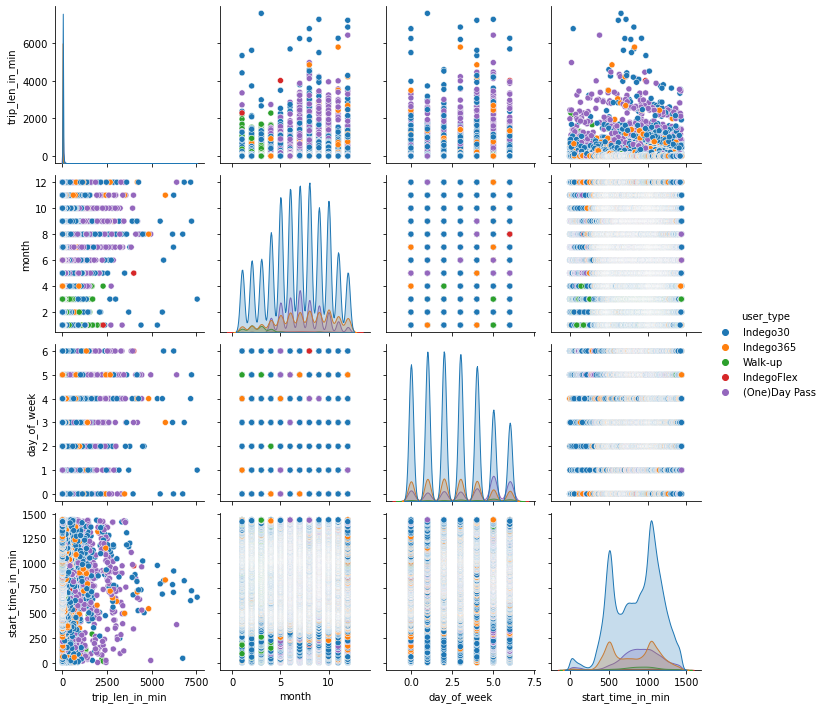

In [31]:
# takes about 7min
sns.pairplot(data=X_plot[["user_type", "trip_len_in_min", "month",
                          "day_of_week", "start_time_in_min"]], hue="user_type")


## K Means


In [32]:
from sklearn.cluster import KMeans


In [33]:
# lower this for faster compute times. Curve flattens most before 10 clusters
k_max = 25


### Find optimal number of K Means


In [34]:
clusters = []
losses = []
# takes around 7 minutes with kmax=25 for me
for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(data_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)


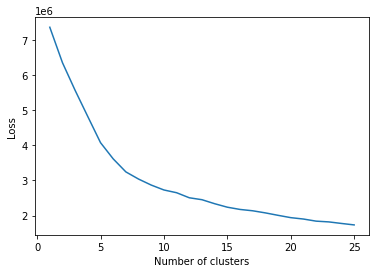

In [35]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()


##### zooming in


(0.0, 10.0)

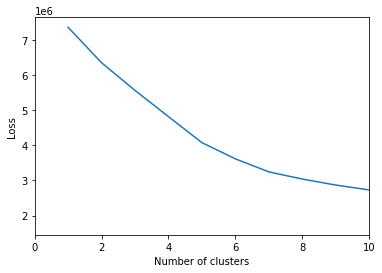

In [36]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0, 10])


In [37]:
# refit algorithm
n_means = KMeans(n_clusters=5)
n_means.fit(data_scaled)

# match records to clusters by calling predict
n_means.predict(data_scaled)
data_scaled


array([[-0.54746653, -0.0407658 , -2.00077214, ...,  1.70931296,
        -0.91416358, -0.43159954],
       [ 0.62071087,  6.87542253, -2.00077214, ...,  1.70931296,
        -0.91416358, -0.43159954],
       [-0.54746653,  0.00917058, -2.00077214, ..., -0.58503037,
        -0.91416358, -0.43159954],
       ...,
       [-0.54746653,  5.20255387,  1.76789776, ..., -0.58503037,
        -0.91416358, -0.43159954],
       [ 1.78888826, -0.09070218,  1.76789776, ..., -0.58503037,
        -0.91416358, -0.43159954],
       [-0.54746653, -0.14063856,  1.76789776, ...,  1.70931296,
        -0.91416358, -0.43159954]])

In [38]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven"]

X_plot["cluster"] = n_means.predict(data_scaled)
X_plot["cluster"] = X_plot["cluster"].apply(lambda x: numbers[x])
mapping = {'Indego30': 1, 'Indego365': 2,
           '(One)Day Pass': 3, "IndegoFlex": 4, "Walk-up": 5}
X_plot = X_plot.replace({"user_type": mapping})
X_plot


user_type  trip_len_in_min  month  day_of_week  start_time_in_min  \
0               1               18      1            0                 24   
1               2              572      1            0                 38   
2               1               22      1            0                 48   
3               1               21      1            0                 63   
4               1                4      1            0                 65   
...           ...              ...    ...          ...                ...   
668579          3               46     12            0               1398   
668580          1               41     12            0               1405   
668581          1              438     12            0               1406   
668582          3               14     12            0               1413   
668583          1               10     12            0               1419   

        same_start_end  is_start_educational_institution  \
0                False                                 0   
1                False                                 0   
2                False                                 0   
3                False                                 0   
4                False                                 1   
...                ...                               ...   
668579            True                                 0   
668580            True                                 0   
668581            True                                 0   
668582           False                                 0   
668583           False                                 0   

        is_start_start_parking_lot  is_start_sight_or_park  is_pt_station  \
0                                0                       1              0   
1                                0                       1              0   
2                                1                       0              0   
3                                0                       0              1   
4                                0                       0              0   
...                            ...                     ...            ...   
668579                           0                       1              0   
668580                           0                       1              0   
668581                           1                       0              0   
668582                           1                       0              0   
668583                           0                       1              0   

        is_residential_area cluster  
0                         0   three  
1                         0   three  
2                         0    four  
3                         0     one  
4                         0     two  
...                     ...     ...  
668579                    0   three  
668580                    0   three  
668581                    0    four  
668582                    0    four  
668583                    0   three  

[668584 rows x 12 columns]

## Analysis of derived clusters


In [39]:
def print_station_types(cluster_i, i):
    sum_parking, sum_sight_park, sum_pt_station, sum_educational, sum_residential = 0, 0, 0, 0, 0
    # you can use any station type here as they are all non non-valued
    for index, data in cluster_i["is_start_start_parking_lot"].items():
        sum_parking = sum_parking + \
            cluster_i["is_start_start_parking_lot"][index]
        sum_sight_park = sum_sight_park + \
            cluster_i['is_start_sight_or_park'][index]
        sum_pt_station = sum_pt_station + cluster_i['is_pt_station'][index]
        sum_educational = sum_educational + \
            cluster_i['is_start_educational_institution'][index]
        sum_residential = sum_residential + \
            cluster_i['is_residential_area'][index]
    print("In cluster {0} we have {1} instances of rides starting from a parking lot.".format(
        i, str(sum_parking)))
    print("In cluster {0} we have {1} instances of rides starting from a sight or park.".format(
        i, str(sum_sight_park)))
    print("In cluster {0} we have {1} instances of rides starting from a public transport station.".format(
        i, str(sum_pt_station)))
    print("In cluster {0} we have {1} instances of rides starting from an educational institution.".format(
        i, str(sum_educational)))
    print("In cluster {0} we have {1} instances of rides starting from a residential area.".format(
        i, str(sum_residential)))


In [40]:
def print_avergae_start_time(cluster_i, i):
    avg_start_min = cluster_i.describe()['start_time_in_min']['mean']
    hour = int(avg_start_min // 60)
    minutes = int(avg_start_min % 60)
    print("In cluster {0} the average start time is {1}:{2}.".format(
        i, hour, minutes))


In [41]:
def print_number_instances(cluster_i, i):
    print("In cluster {0} we have {1} number of instances assigned.".format(
        i, cluster_i.describe()['user_type']['count']))


In [42]:
def print_avergae_weekday(cluster_i, i):
    print("In cluster {0} the average day of the week the bike is rented is  {1}.".format(
        i,  cluster_i.describe()['day_of_week']['mean']))


In [43]:
def print_average_month(cluster_i, i):
    print("In cluster {0}  the average month the bike is rented is {1}.".format(
        i,  cluster_i.describe()['month']['mean']))


In [44]:
def print_avergae_trip_length(cluster_i, i):
    print("In cluster {0}  the average trip length is {1} minutes.".format(
        i,  cluster_i.describe()['trip_len_in_min']['mean']))


In [45]:
def print_user_distribution(cluster_i, i):
    print("In cluster {0} we have {1} rides being taken by user type 'Indego30'.".format(
        str(i), cluster_i[cluster_i['user_type'] == 1]['is_start_educational_institution'].count()))
    print("In cluster {0} we have {1} rides being taken by user type 'Indego365'.".format(
        str(i), cluster_i[cluster_i['user_type'] == 2]['is_start_educational_institution'].count()))
    print("In cluster {0} we have {1} rides being taken by user type 'One Day Pass' or 'Day Pass.".format(
        str(i), cluster_i[cluster_i['user_type'] == 3]['is_start_educational_institution'].count()))
    print("In cluster {0} we have {1} rides being taken by user type 'Indego Flex'.".format(
        str(i), cluster_i[cluster_i['user_type'] == 4]['is_start_educational_institution'].count()))
    print("In cluster {0} we have {1} rides being taken by user type 'Walk-up'.".format(str(
        i), cluster_i[cluster_i['user_type'] == 5]['is_start_educational_institution'].count()))


In [46]:
mapping_cluster_number = {0: "zero", 1: "one", 2: "two", 3: "three", 4: "four"}


In [47]:
print("As the analysis typically exceeds the size limit. Open the full output data in a text editor ")
for i in range(5):
    cluster_i = X_plot[X_plot["cluster"] == mapping_cluster_number.get(i)]
    print("*******************************************************")
    print("Analysis cluster {0}".format(i))
    print_user_distribution(cluster_i, i)
    print("------------------")
    print_number_instances(cluster_i, i)
    print("------------------")
    print_avergae_start_time(cluster_i, i)
    print("------------------")
    print_avergae_weekday(cluster_i, i)
    print("------------------")
    print_average_month(cluster_i, i)
    print("------------------")
    print_avergae_trip_length(cluster_i, i)
    print("------------------")
    print_station_types(cluster_i, i)


As the analysis typically exceeds the size limit. Open the full output data in a text editor 
*******************************************************
Analysis cluster 0
In cluster 0 we have 78587 rides being taken by user type 'Indego30'.
In cluster 0 we have 16603 rides being taken by user type 'Indego365'.
In cluster 0 we have 7923 rides being taken by user type 'One Day Pass' or 'Day Pass.
In cluster 0 we have 552 rides being taken by user type 'Indego Flex'.
In cluster 0 we have 1298 rides being taken by user type 'Walk-up'.
------------------
In cluster 0 we have 104963.0 number of instances assigned.
------------------
In cluster 0 the average start time is 13:3.
------------------
In cluster 0 the average day of the week the bike is rented is  2.81354382020331.
------------------
In cluster 0  the average month the bike is rented is 6.847241408877414.
------------------
In cluster 0  the average trip length is 19.37316959309471 minutes.
------------------
In cluster 0 we have 0 

In [48]:
series_avg_user = X_plot.groupby("cluster").describe()['user_type']['mean']
series_avg_user.name = "Average user type"
series_avg_trip = X_plot.groupby("cluster").describe()[
    'trip_len_in_min']['mean']
series_avg_trip.name = "Average trip length"
series_avg_pt_station = X_plot.groupby("cluster").describe()[
    'is_pt_station']['mean']
series_avg_pt_station.name = "Average public transport station"
series_avg_residential = X_plot.groupby("cluster").describe()[
    'is_residential_area']['mean']
series_avg_residential.name = "Average residential area"
series_avg_educational = X_plot.groupby("cluster").describe()[
    'is_start_educational_institution']['mean']
series_avg_educational.name = "Average educational institution"
series_avg_sight_or_park = X_plot.groupby("cluster").describe()[
    'is_start_sight_or_park']['mean']
series_avg_sight_or_park.name = "Average sight or park"
series_avg_parking_lot = X_plot.groupby("cluster").describe()[
    'is_start_start_parking_lot']['mean']
series_avg_parking_lot.name = "Average parking lot"
series_avg_start_time = X_plot.groupby("cluster").describe()[
    'start_time_in_min']['mean']
series_avg_start_time.name = "Average start time"
series_number_instances = X_plot.groupby("cluster").describe()[
    'user_type']['count']
series_number_instances.name = "Instances in cluster"
series_avg_day = X_plot.groupby("cluster").describe()['day_of_week']['mean']
series_avg_day.name = "Average weekday"
series_avg_month = X_plot.groupby("cluster").describe()['month']['mean']
series_avg_month.name = "Average month"
series_cluster = X_plot.groupby("cluster").describe().index.to_series()
series_cluster.name = "cluster"
df = pd.concat([series_avg_user, series_avg_trip, series_avg_pt_station, series_avg_residential, series_avg_educational, series_avg_sight_or_park, series_avg_parking_lot, series_avg_start_time,
                series_number_instances, series_avg_day, series_avg_month, series_cluster], axis=1)


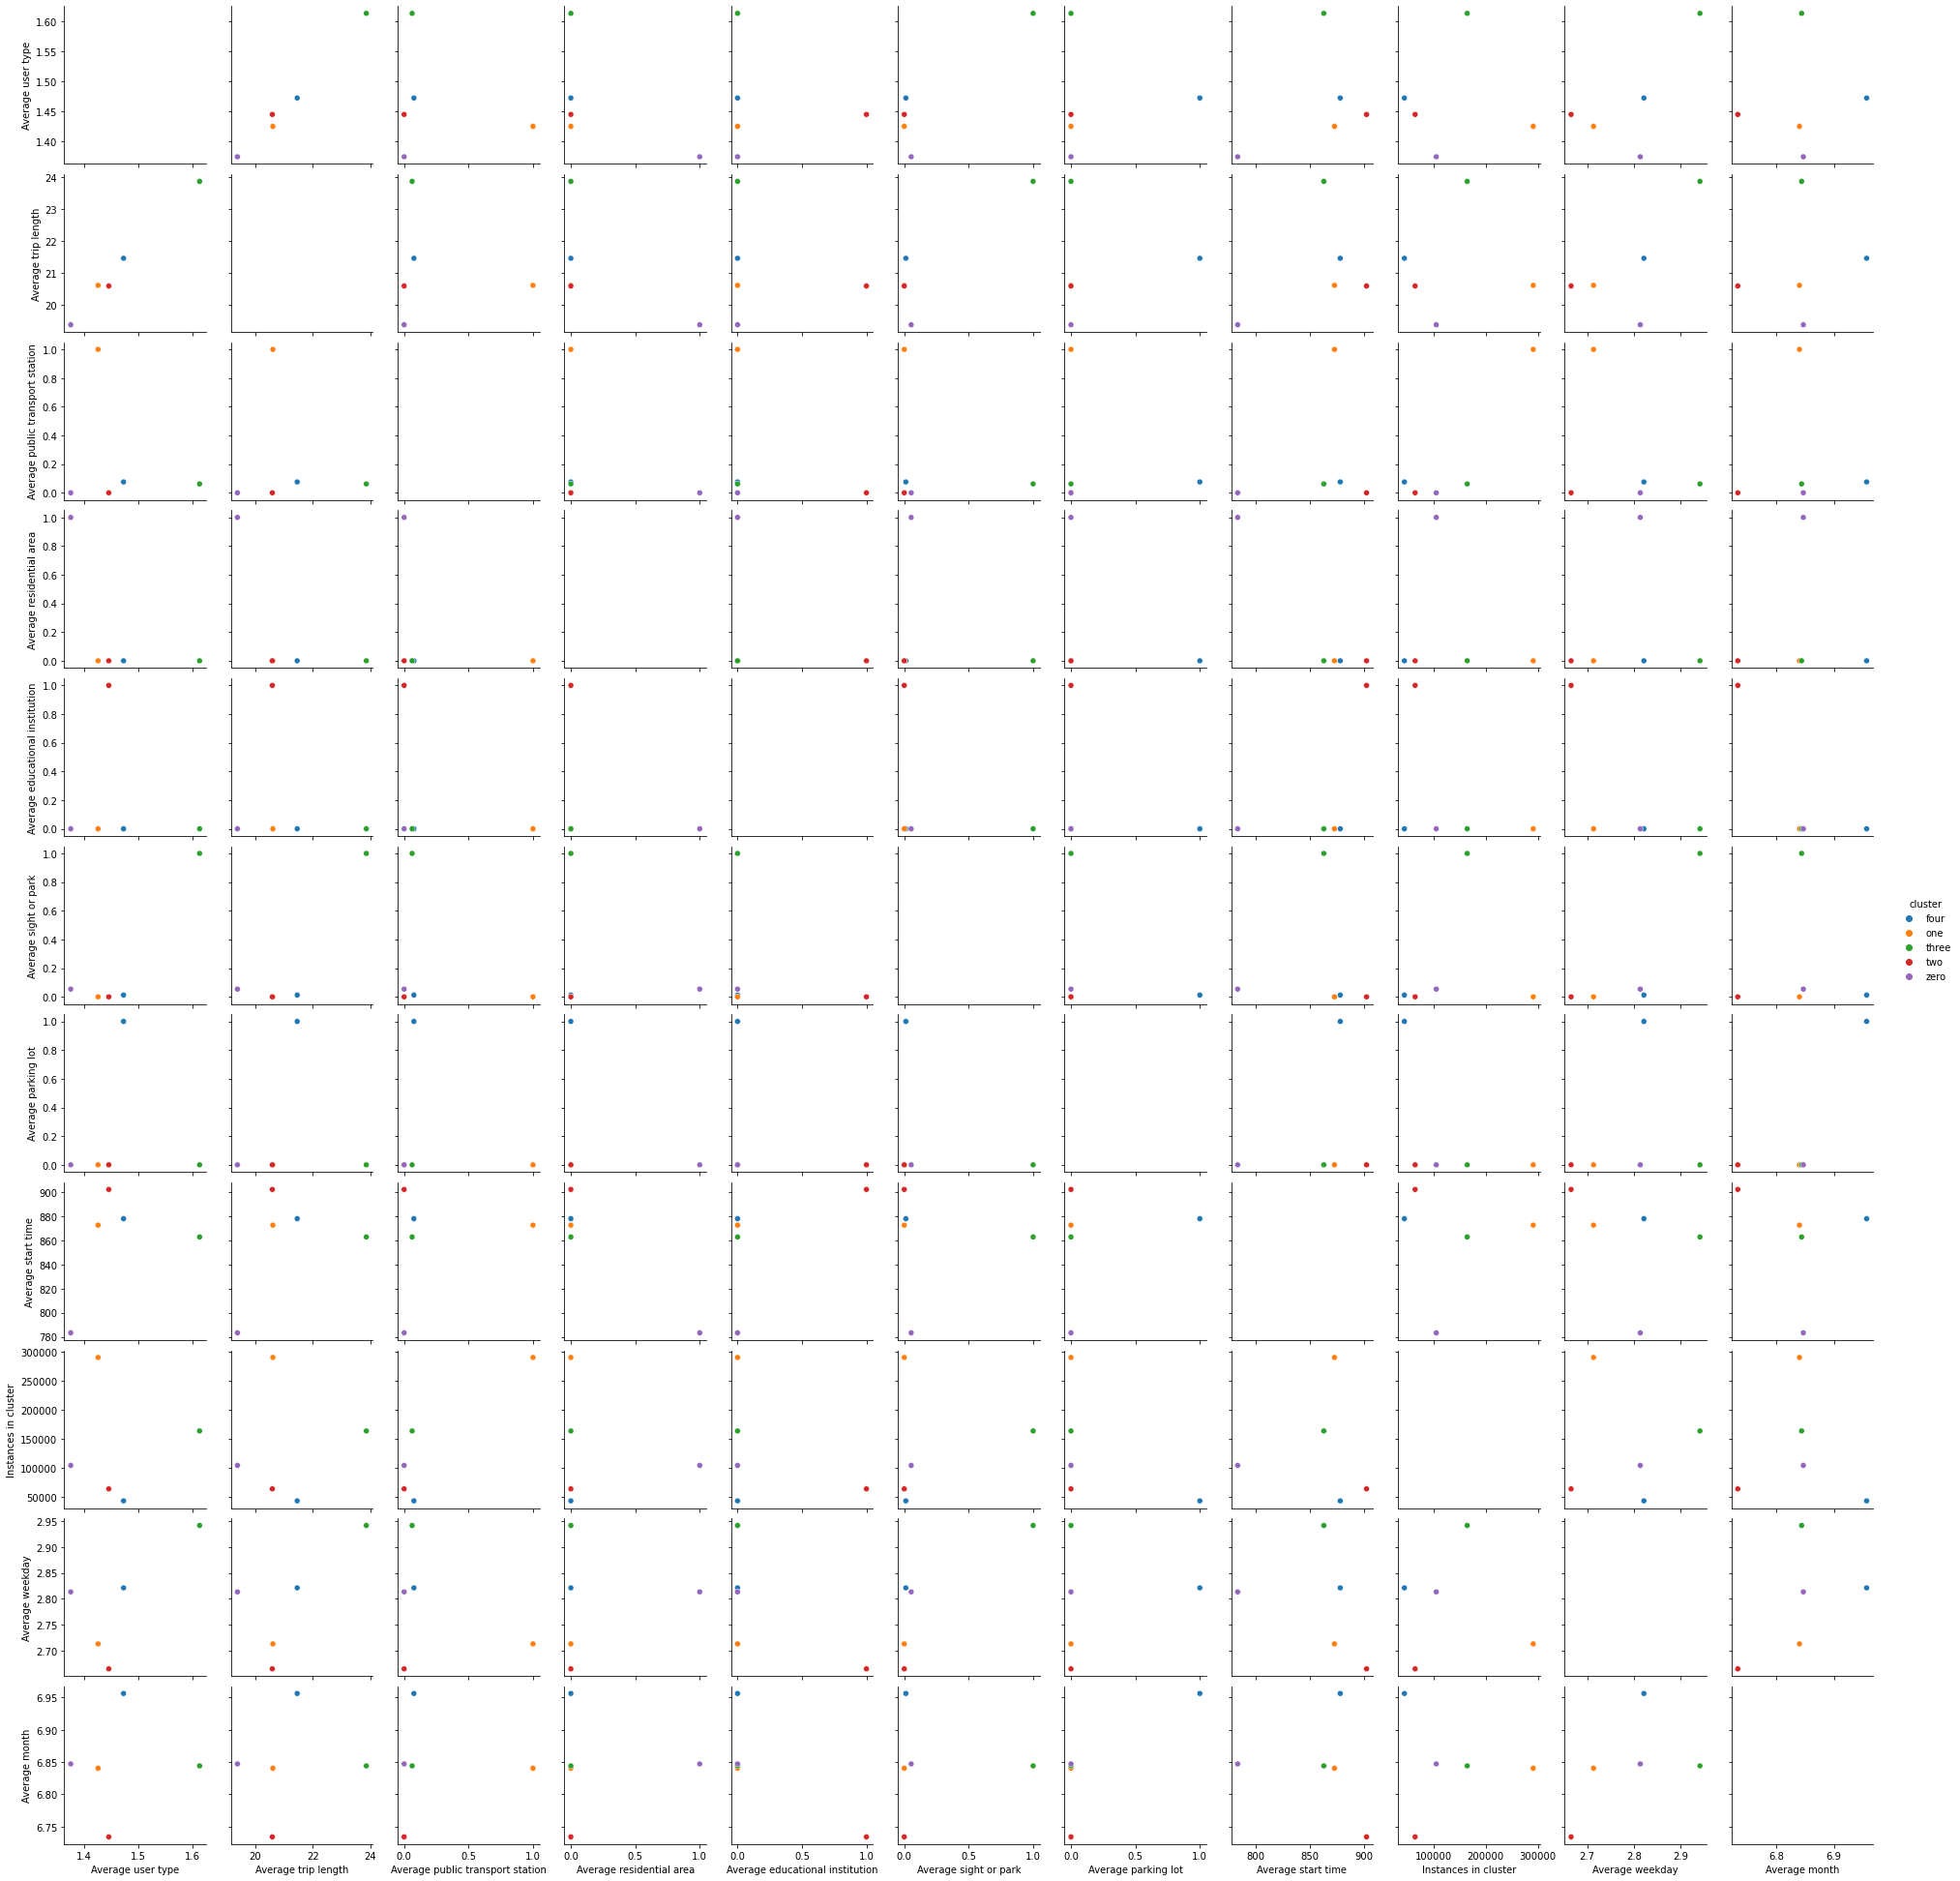

In [49]:
sns.pairplot(df, hue="cluster")
